In [1]:
import numpy as np
import csv
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import scipy.stats
import pandas as pd
import mplhep as hep
from iminuit import cost, Minuit
# faster than scipy.stats functions
from numba_stats import truncnorm, truncexpon, norm, expon
from scipy.stats import multivariate_normal as mvnorm
# hep.style.use("CMS")

## Import and process files

In [2]:
t_max = []
t_start = []
t_max3 = []
t_start3 = []
t_CFD_A3 = []
t_CFD_A3_maison = []
t_CFD_A4 = []
delay = []
delay_cfd_maison = []
A = []
A_A3 = []
offset = []
offset_A3 = []
Ishort = []
Itot = []

T_short = 58 #ns
T_tot = 250 #ns
N = 100000
dl = 4 #ns

# filenames = [f"100k_cf_80/100k_cf_80_{i}.ecor" for i in range(8)] 
filenames = [f"100k_cf_30_new_cfd/100k_cf_30_new_cfd_{i}.ecor" for i in range(8)] 
# filenames += [f"100k_cf_30/100k_cf_30_{i}.ecor" for i in range(2)] 
# filenames = [f"Cf_14k_1220_2000.ecor"]

for name in filenames:
    print(f"Opening {name}")
    df_temp = pd.read_csv(name, skiprows = lambda x: x % 2566 < 6, delimiter = ";" , names=["t1","A1","t2","A2", "t3", "A3","t4","A4"])
    # df_temp = pd.DataFrame(columns=["t1","A1","t2","A2", "t3", "A3","t4","A4"])
    
    deriv = df_temp.diff()

    df_temp["d1"] = deriv["A1"]/deriv["t1"]
    df_temp["d2"] = deriv["A2"]/deriv["t2"]
    df_temp["d3"] = deriv["A3"]/deriv["t3"]
    df_temp["d4"] = deriv["A4"]/deriv["t4"]
    
    print("Derivatives computed")
    
    
    n = int(np.ceil(len(df_temp)/2560))
    
    print(n)

    for i in range(n):
    
    

        df0 = df_temp[2560*i:2560*(i+1)]

        t_max_temp = df0.at[df0["A4"].idxmin(),"t4"]
        t_max.append(t_max_temp)

        t_start_temp = df0[df0['d4'] <= max(-5,df0['d4'].min())].iloc[0]["t4"] - 2
        t_start.append(t_start_temp)
        
        t_max_temp3 = df0.at[df0["A3"].idxmin(),"t3"]
        t_max3.append(t_max_temp3)

        t_start_temp3 = df0[df0['d3'] <= max(-100,df0['d3'].min())].iloc[0]["t3"] - 2
        t_start3.append(t_start_temp3)

        t_CFD_A3_temp = df0.at[df0["d1"].idxmin(),"t1"]
        t_CFD_A3.append(t_CFD_A3_temp)

        t_CFD_A4_temp = df0.at[df0["d2"].idxmin(),"t2"]
        t_CFD_A4.append(t_CFD_A4_temp)

        delay.append(t_CFD_A4_temp-t_CFD_A3_temp)

        df1=df0.to_numpy()
        mins = np.argmin(df1,axis=0)
        IDminA3 = mins[5]
        IDminA4 = mins[7]

        offset_temp = np.mean(df1[IDminA4-200:IDminA4-150,7])
        offset.append(offset_temp)
        
        offset_temp3 = np.mean(df1[:IDminA3-150,5])
        offset_A3.append(offset_temp3)

        A_temp = -min(df0["A4"]) + offset_temp
        A.append(A_temp)
        
        A_temp_A3 = -min(df0["A3"]) + offset_temp3
        A_A3.append(A_temp_A3)
        
        
        A3_norm = -(df0["A3"]-offset_temp3)/A_temp_A3

        A3_norm_shifted = A3_norm.shift(periods=dl*2)

        A3_retourne_att = -A3_norm*0.4

        A3_sum = A3_norm_shifted + A3_retourne_att



    #     print(df0,df0.index[np.where(np.diff(np.sign(np.array(A3_sum))))])


        zeros_crossing = df0.iloc[np.where(np.diff(np.sign(np.array(A3_sum))))]

        if len(zeros_crossing[zeros_crossing['t3']>t_start_temp3]['t3'])==0 :
            
            CFD_A3_time = t_start_temp3
        
        else : 
            CFD_A3_time = zeros_crossing[zeros_crossing['t3']>t_start_temp3]['t3'].iloc[0]

        t_CFD_A3_maison.append(CFD_A3_time)
        
        delay_cfd_maison.append(t_CFD_A4_temp-CFD_A3_time)
        
        dft1 = -(df0[(df0['t4'] > t_CFD_A4_temp - 45 + T_short) & (df0['t4'] < t_CFD_A4_temp - 45 + T_tot ) ]["A4"] - offset_temp)


        Ishort_temp = dft1.sum()
        Ishort.append(Ishort_temp)


        dft2 = -(df0[(df0['t4'] > t_CFD_A4_temp - 45 ) & (df0['t4'] < t_CFD_A4_temp - 45 + T_tot) ]["A4"] - offset_temp)    

        Itot_temp = dft2.sum()
        Itot.append(Itot_temp)
    



Opening 100k_cf_30_new_cfd/100k_cf_30_new_cfd_0.ecor
Derivatives computed
14051
Opening 100k_cf_30_new_cfd/100k_cf_30_new_cfd_1.ecor
Derivatives computed
14045
Opening 100k_cf_30_new_cfd/100k_cf_30_new_cfd_2.ecor
Derivatives computed
14045
Opening 100k_cf_30_new_cfd/100k_cf_30_new_cfd_3.ecor
Derivatives computed
14047


/local/home/administrator/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/local/home/administrator/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Opening 100k_cf_30_new_cfd/100k_cf_30_new_cfd_4.ecor
Derivatives computed
14048
Opening 100k_cf_30_new_cfd/100k_cf_30_new_cfd_5.ecor
Derivatives computed
14048
Opening 100k_cf_30_new_cfd/100k_cf_30_new_cfd_6.ecor
Derivatives computed
14047


/local/home/administrator/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/local/home/administrator/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Opening 100k_cf_30_new_cfd/100k_cf_30_new_cfd_7.ecor
Derivatives computed
1670


In [3]:
t_start_temp3



491.6

In [80]:
PSD = np.array(Ishort)/np.array(Itot)
PSD = PSD
delay_arr = np.array(delay)
delay_maison_arr = np.array(delay_cfd_maison)
CFD = np.array(t_CFD_A4)
MAX = np.array(t_max3)
START = np.array(t_start3)
DELAY = CFD-(MAX+START)/2
A_arr = np.array(A)
Itot_arr = np.array(Itot)

PSD_0 = PSD[A_arr<900]
delay_0 = delay_arr[A_arr<900] 
A_0 = A_arr[A_arr<900]
Itot_0 = Itot_arr[A_arr<900]


 
    
#gammas selection 30ns < DeltaT < 38ns
minTgamma = 45
maxTgamma = 60
PSD_gammas = PSD_0[(delay_0>minTgamma)&(delay_0<maxTgamma)]
delay_gammas = delay_0[(delay_0>minTgamma)&(delay_0<maxTgamma)]
A_gammas = A_0[(delay_0>minTgamma)&(delay_0<maxTgamma)]
Itot_gammas = Itot_0[(delay_0>minTgamma)&(delay_0<maxTgamma)]
E_gammas = 1.25/19640*Itot_gammas

ind_gammas = np.where((delay_arr>minTgamma)&(delay_arr<maxTgamma)&(PSD<0.12)&(A_arr<900))[0]

#neutrons selection 45ns < DeltaT < 80ns
minTneutron = 67
maxTneutron = 130
PSD_neutrons = PSD_0[(delay_0>minTneutron)&(delay_0<maxTneutron)]
delay_neutrons = delay_0[(delay_0>minTneutron)&(delay_0<maxTneutron)]
A_neutrons = A_0[(delay_0>minTneutron)&(delay_0<maxTneutron)]

real_delay_neutrons = delay_neutrons - 52

D = 0.5 #m
m = 939.565 #MeV
c = 3e8 #m/s

beta = D/((real_delay_neutrons+0.5*np.random.random(len(real_delay_neutrons))-0.25)*c*1e-9)

E_neutrons = m*(1/np.sqrt(1-(beta)**2)) - m


ind_neutrons = np.where((delay_arr>minTneutron)&(delay_arr<maxTneutron)&(PSD>0.15)&(A_arr<900))[0]



PSD_all = np.concatenate([PSD_gammas,PSD_neutrons])
delay_all = np.concatenate([delay_gammas,delay_neutrons])
A_all = np.concatenate([A_gammas,A_neutrons])
E_all = np.concatenate([E_gammas,E_neutrons])


PSD_all_eq = np.concatenate([PSD_gammas[0:len(PSD_neutrons)],PSD_neutrons])
delay_all_eq = np.concatenate([delay_gammas[0:len(PSD_neutrons)],delay_neutrons])
A_all_eq = np.concatenate([A_gammas[0:len(PSD_neutrons)],A_neutrons])
E_all_eq = np.concatenate([E_gammas[0:len(PSD_neutrons)],E_neutrons])

print(f"Nombre de gammas : {len(E_gammas)} et nombre de neutrons : {len(E_neutrons)}")
real_delay_neutrons

Nombre de gammas : 35241 et nombre de neutrons : 18377


array([24. , 58. , 27. , ..., 36.5, 48.5, 65.5])

array([-0.06356449,  0.16391081, -0.21593236, -0.06560075, -0.03800618])

In [5]:
index_nul = np.where((delay_maison_arr>80)&(PSD<0.13))
index_nul_0 = np.where((delay_0>80)&(PSD_0<0.13))

In [6]:
len(index_nul_0[0])/len(PSD_0)

0.04930922280898277

In [7]:
print("Total events :", len(PSD_0), ",total gamma :",len(PSD_gammas),  ",total neutron :",len(PSD_neutrons), ",total bruit :",len(index_nul_0[0]))


Total events : 93735 ,total gamma : 35241 ,total neutron : 18377 ,total bruit : 4622


Mean neutrons energy 1.2537021125163124 MeV


Text(0, 0.5, 'Counts')

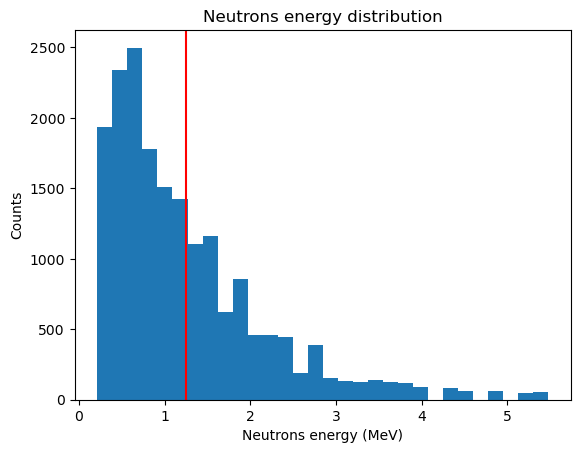

In [8]:
print(f"Mean neutrons energy {np.mean(E_neutrons)} MeV")
plt.hist(E_neutrons,bins=30)
plt.axvline(np.mean(E_neutrons),color='red')
plt.title("Neutrons energy distribution")
plt.xlabel('Neutrons energy (MeV)')
plt.ylabel('Counts')

Mean neutrons energy 0.9076775601609597 MeV


Text(0, 0.5, 'Counts')

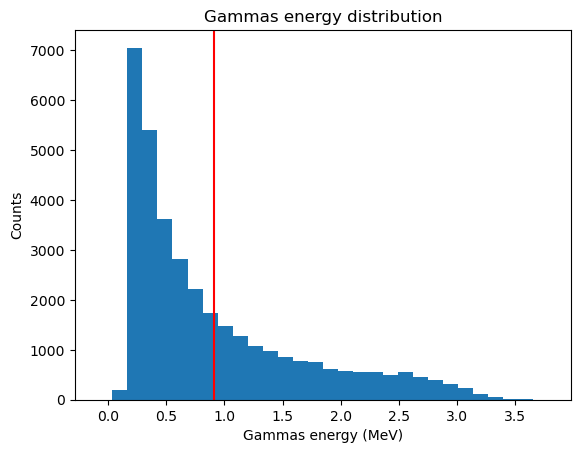

In [9]:
print(f"Mean neutrons energy {np.mean(E_gammas)} MeV")
plt.hist(E_gammas,bins=30)
plt.axvline(np.mean(E_gammas),color='red')
plt.title("Gammas energy distribution")
plt.xlabel('Gammas energy (MeV)')
plt.ylabel('Counts')

In [10]:
min(E_neutrons)

0.2145625264897717

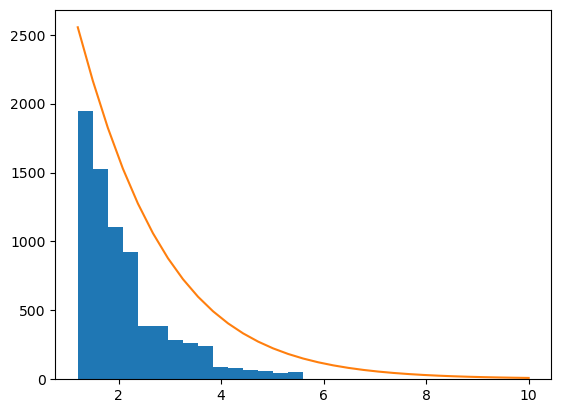

In [11]:
T = 1.3
hist, bins = np.histogram(E_neutrons,bins=30, range=[1.2,10])
plt.hist(E_neutrons,bins=30,range=[1.2,10])
plt.plot(bins,-2500/0.4*scipy.special.gammainc(3/2, bins/T)/(T**1.5)+4220)


(array([  81.,   75.,   85.,   85.,   97.,   95.,   86.,  113.,  102.,
         111.,  132.,  126.,  214.,  302.,  332.,  435.,  577.,  788.,
        1200., 1739., 2719., 3483., 4232., 4404., 3971., 3190., 2174.,
        1342.,  749.,  478.,  406.,  369.,  345.,  310.,  308.,  292.,
         254.,  207.,  152.,  143.,  111.,   81.,   68.,   57.,   60.,
          39.,   81.,   67.,   50.,   64.,   50.,   46.,   43.,   61.,
          41.,   54.,   48.,   59.,   64.,   82.,   91.,  124.,  128.,
         139.,  135.,  125.,  168.,  205.,  202.,  189.,  217.,  228.,
         247.,  228.,  219.,  240.,  288.,  268.,  318.,  310.,  314.,
         333.,  285.,  279.,  260.,  276.,  276.,  273.,  285.,  299.,
         286.,  268.,  285.,  271.,  258.,  263.,  283.,  244.,  233.,
         231.,  272.,  230.,  229.,  223.,  202.,  193.,  212.,  218.,
         240.,  234.,  214.,  221.,  190.,  180.,  178.,  181.,  177.,
         165.,  176.,  163.,  171.,  184.,  161.,  140.,  150.,  137.,
      

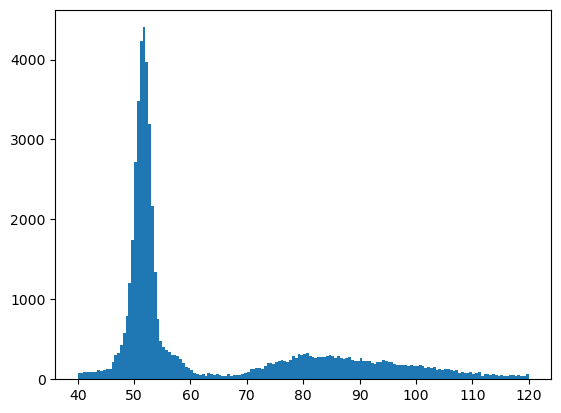

In [12]:
plt.hist(delay_0,bins=160,range=[40
                               ,120])

(array([  49.,   67.,   85.,   95.,   92.,  116.,  107.,  131.,  105.,
         131.,  148.,  148.,  155.,  186.,  274.,  375.,  393.,  603.,
         747., 1080., 1565., 2365., 3216., 4200., 4758., 4819., 4266.,
        3115., 1957., 1175.,  709.,  471.,  338.,  303.,  285.,  253.,
         202.,  224.,  194.,  141.,  138.,  113.,   87.,   63.,   56.,
          54.,   49.,   44.,   63.,   53.,   62.,   64.,   58.,   57.,
          56.,   66.,   68.,   73.,   90.,   93.,  105.,  118.,  118.,
         128.,  163.,  168.,  165.,  178.,  207.,  217.,  219.,  222.,
         226.,  241.,  239.,  248.,  252.,  269.,  292.,  308.,  304.,
         308.,  318.,  313.,  282.,  295.,  279.,  278.,  275.,  297.,
         298.,  296.,  297.,  270.,  282.,  279.,  263.,  269.,  277.,
         231.,  242.,  238.,  250.,  230.,  211.,  228.,  208.,  220.,
         226.,  234.,  232.,  233.,  221.,  236.,  169.,  212.,  181.,
         184.,  172.,  162.,  167.,  165.,  173.,  167.,  156.,  142.,
      

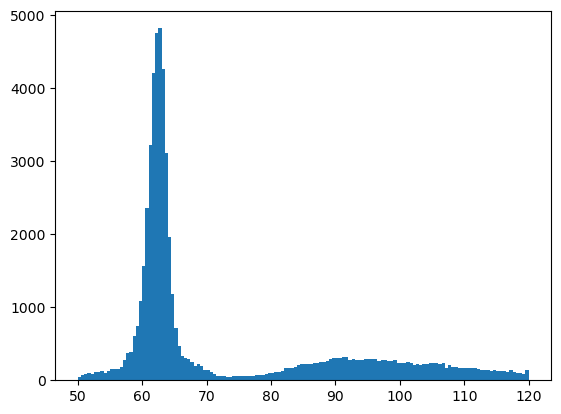

In [13]:
plt.hist(delay_maison_arr,bins=140,range=[50,120])

## Oscillo plots

0.09139294209766154 189.5


/tmp/ipykernel_819600/452255193.py:31: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


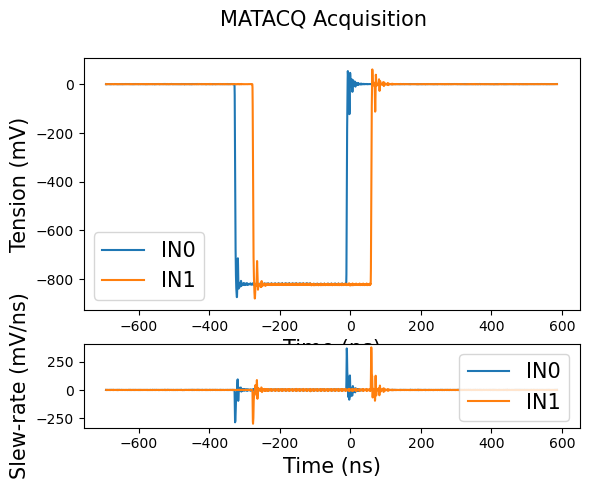

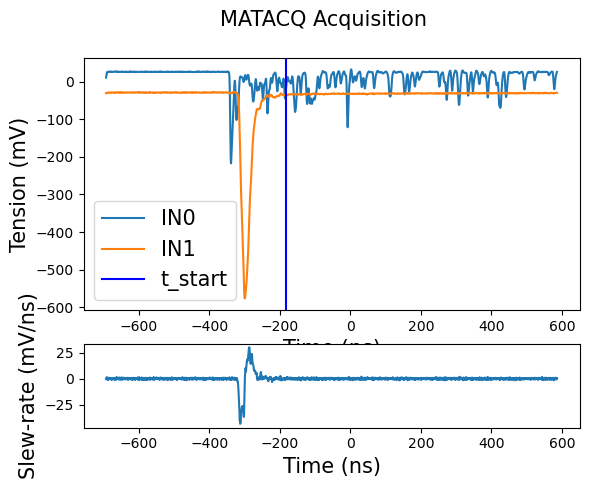

In [14]:

def plot_debug(n_plot):
    
    fig, (ax1, ax2) = plt.subplots(2,1, gridspec_kw={'height_ratios': [3, 1]})
    fig.suptitle(
       "MATACQ Acquisition",
       fontsize=15,
    )
    
    
    ax1.plot(df_temp.iloc[2560*n_plot:2560*(n_plot+1),0],df_temp.iloc[2560*n_plot:2560*(n_plot+1),1],label='IN0')
    ax1.plot(df_temp.iloc[2560*n_plot:2560*(n_plot+1),2],df_temp.iloc[2560*n_plot:2560*(n_plot+1),3],label='IN1')
    
    ax1.set_xlabel("Time (ns)", fontsize=15)
    ax1.set_ylabel("Tension (mV)", fontsize=15)
    # ax1.set_ylim(0, 25)
    
    ax1.legend(fontsize=15)
    
    
    
    ax2.plot(df_temp.iloc[2560*n_plot:2560*(n_plot+1),0],df_temp.iloc[2560*n_plot:2560*(n_plot+1),8],label='IN0')
    ax2.plot(df_temp.iloc[2560*n_plot:2560*(n_plot+1),2],df_temp.iloc[2560*n_plot:2560*(n_plot+1),9],label='IN1')
    
    ax2.set_xlabel("Time (ns)", fontsize=15)
    ax2.set_ylabel("Slew-rate (mV/ns)", fontsize=15)
    # ax1.set_ylim(0, 25)
    
    ax2.legend(fontsize=15)
    
    # fig.tight_layout()
    fig.show()
    
    
def plot_debug2(n_plot):
    
    fig, (ax1, ax2) = plt.subplots(2,1, gridspec_kw={'height_ratios': [3, 1]})
    fig.suptitle(
       "MATACQ Acquisition",
       fontsize=15,
    )
    
    
    ax1.plot(df_temp.iloc[2560*n_plot:2560*(n_plot+1),4],df_temp.iloc[2560*n_plot:2560*(n_plot+1),5],label='IN0')
    ax1.plot(df_temp.iloc[2560*n_plot:2560*(n_plot+1),6],df_temp.iloc[2560*n_plot:2560*(n_plot+1),7],label='IN1')
    ax1.axvline(x = t_CFD_A4[n_plot]-45, color = 'b', label = 't_start')
    ax1.set_xlabel("Time (ns)", fontsize=15)
    ax1.set_ylabel("Tension (mV)", fontsize=15)
    # ax1.set_ylim(0, 25)
    
    ax1.legend(fontsize=15)   
    
#     ax2.plot(df_temp.iloc[2560*n_plot:2560*(n_plot+1),0],df_temp.iloc[2560*n_plot:2560*(n_plot+1),10],label='IN0')
    ax2.plot(df_temp.iloc[2560*n_plot:2560*(n_plot+1),2],df_temp.iloc[2560*n_plot:2560*(n_plot+1),11],label='IN1')
    
    ax2.set_xlabel("Time (ns)", fontsize=15)
    ax2.set_ylabel("Slew-rate (mV/ns)", fontsize=15)
    # ax1.set_ylim(0, 25)
    
#     ax2.legend(fontsize=15)


#CFD foireu n=304, 306, 308, 312, 317,318, 325,330
n_plot = index_nul[0][17]


plot_debug(n_plot)
#
plot_debug2(n_plot)
    
    
print(PSD[n_plot], delay_maison_arr[n_plot] )

## Debug PSD

ValueError: v cannot be empty

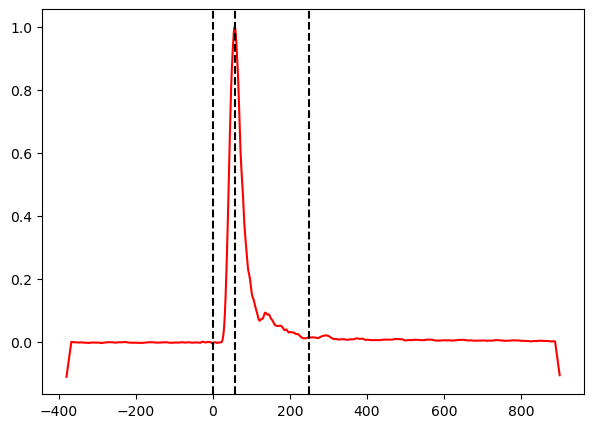

In [15]:
n_plot_gamma = 515
n_plot_neutron =   3655
# import random
# n_plot_gamma = ind_gammas[random.randint(0,len(ind_gammas))]
# n_plot_neutron = ind_neutrons[random.randint(0,len(ind_neutrons))]

def plot_debug(n_plots):
    
#     fig, (ax1, ax2) = plt.subplots(2,1, gridspec_kw={'height_ratios': [1, 10]}, figsize = (12,10))
    fig, ax2 = plt.subplots(1,1,figsize = (7,5))
    
    if type(n_plots) == int:
        n_plots = list(n_plots)
    
    for i, n_plot in enumerate(n_plots):
        
        if not i:
            label = "gamma"
            color = "red"
            
        else: 
            label = "neutron"
            color = "royalblue"
        df0 = df_temp.iloc[2560*n_plot:2560*(n_plot+1)]

#         ax1.plot(df0["t4"],df0["A4"],label='IN0')

#         ax1.axvline(x = t_start[n_plot], color = 'b', label = 't_start')
#         ax1.axvline(x = t_max[n_plot], color = 'g', label = 't_max')
#         ax1.axhline(y = offset[n_plot], color = 'r', label = 'offset')

#         ax1.set_xlabel("Time (ns)", fontsize=15)
#         ax1.set_ylabel("Tension (mV)", fontsize=15
#         ax2.plot(df0["t4"] - (t_CFD_A4[n_plot] - 45) ,-(df0["A4"] -offset[n_plot])/A[n_plot],label=label, color = color)
        ax2.plot(df0["t4"] - (t_CFD_A4[n_plot] - 52) ,-(np.convolve(df0["A4"] ,0.02*np.ones(50), mode="same")-offset[n_plot])/np.max(-(np.convolve(df0["A4"] ,0.02*np.ones(50), mode="same")-offset[n_plot])),label=label, color = color)

        ax2.axvline(x = 58, ls = "--", color = "black")
        ax2.axvline(x = 0,ls = "--", color = "black")
        ax2.axvline(x = 250,ls = "--", color = "black")
        

    ax2.set_ylim(0.005, 1.1)
    ax2.set_yscale("log")
#      ax1.set_xlim(0, 25)
    
    # ax1.set_ylim(0, 25)
    ax2.arrow(0, 0.1, 250, 0, color='black',
          head_length = 5, head_width = 0.01, 
          length_includes_head = True)
    ax2.arrow(250, 0.1, -250, 0, color='black',head_length = 5, head_width = 0.01, length_includes_head = True)
    
    ax2.arrow(58, 0.2, 250-58, 0, color='black',
          head_length = 5, head_width = 0.02, 
          length_includes_head = True)
    ax2.arrow(250, 0.2, 58-250, 0, color='black',head_length = 5, head_width = 0.02, length_includes_head = True)
    ax2.set_xlabel("Time (ns)" ,fontsize = 15)
    ax2.set_ylabel("Amplitude (a.u.)",fontsize = 15)
    
    ax2.legend(fontsize=15, loc = 1, framealpha  = 1 )
    ax2.set_xlim([-10,260])
    ax2.text(150, 0.11,  "$I_{tot}$", fontsize = 20)
    ax2.text(150, 0.22,  "$I_{short}$", fontsize = 20)

plot_debug([n_plot_gamma,n_plot_neutron])
#
def plot_debug_m(n_plot):


    df0 = df_temp.iloc[2560*n_plot:2560*(n_plot+1)]
    plt.plot(df0["t4"] - t_start[n_plot] ,-(np.convolve(df0["A4"], 0.2*np.ones((5,1)))-offset[n_plot])/(A[n_plot]+offset[n_plot]),label= f'{n_plot}')
    plt.xlim(-10, 500)
    
    plt.ylim(0, 1)
    
    
    # ax1.set_ylim(0, 25)
    
    plt.legend(fontsize=10, loc = 1)
    
import random

# plot_debug_m(n_plot)    
# for k in range(5):
#     i=random.randint(0, N)
#     plot_debug_m(i)
#     print(i, Ishort[i]/Itot[i])

In [ ]:
proba = gmm.predict_proba([[delay[n_plot_neutron],PSD[n_plot_neutron]]])
liste = [0,1,2]
liste.remove(np.argmax(np.linalg.det(gmm.covariances_)))
liste.remove(np.argmin(np.linalg.det(gmm.covariances_)))

print(f"The event with a delay of {delay[n_plot_neutron]}ns and a PSD of {PSD[n_plot_neutron]} is likely to be :\n",f"Gamma : {proba[0,np.argmin(np.linalg.det(gmm.covariances_))]*100:.1f}%\n",f"Neutron : {proba[0,liste[0]]*100:.1f}%\n",f"Background : {proba[0,np.argmax(np.linalg.det(gmm.covariances_))]*100:.1f}% \n")





In [ ]:
proba = gmm.predict_proba([[delay[n_plot_gamma],PSD[n_plot_gamma]]])
liste = [0,1,2]
liste.remove(np.argmax(np.linalg.det(gmm.covariances_)))
liste.remove(np.argmin(np.linalg.det(gmm.covariances_)))

print(f"The event with a delay of {delay[n_plot_gamma]}ns and a PSD of {PSD[n_plot_gamma]} is likely to be :\n",f"Gamma : {proba[0,np.argmin(np.linalg.det(gmm.covariances_))]*100:.1f}%\n",f"Neutron : {proba[0,liste[0]]*100:.1f}%\n",f"Background : {proba[0,np.argmax(np.linalg.det(gmm.covariances_))]*100:.1f}% \n")




In [16]:
n_plot_neutron, n_plot_gamma

(3655, 515)

## CFD MAISON

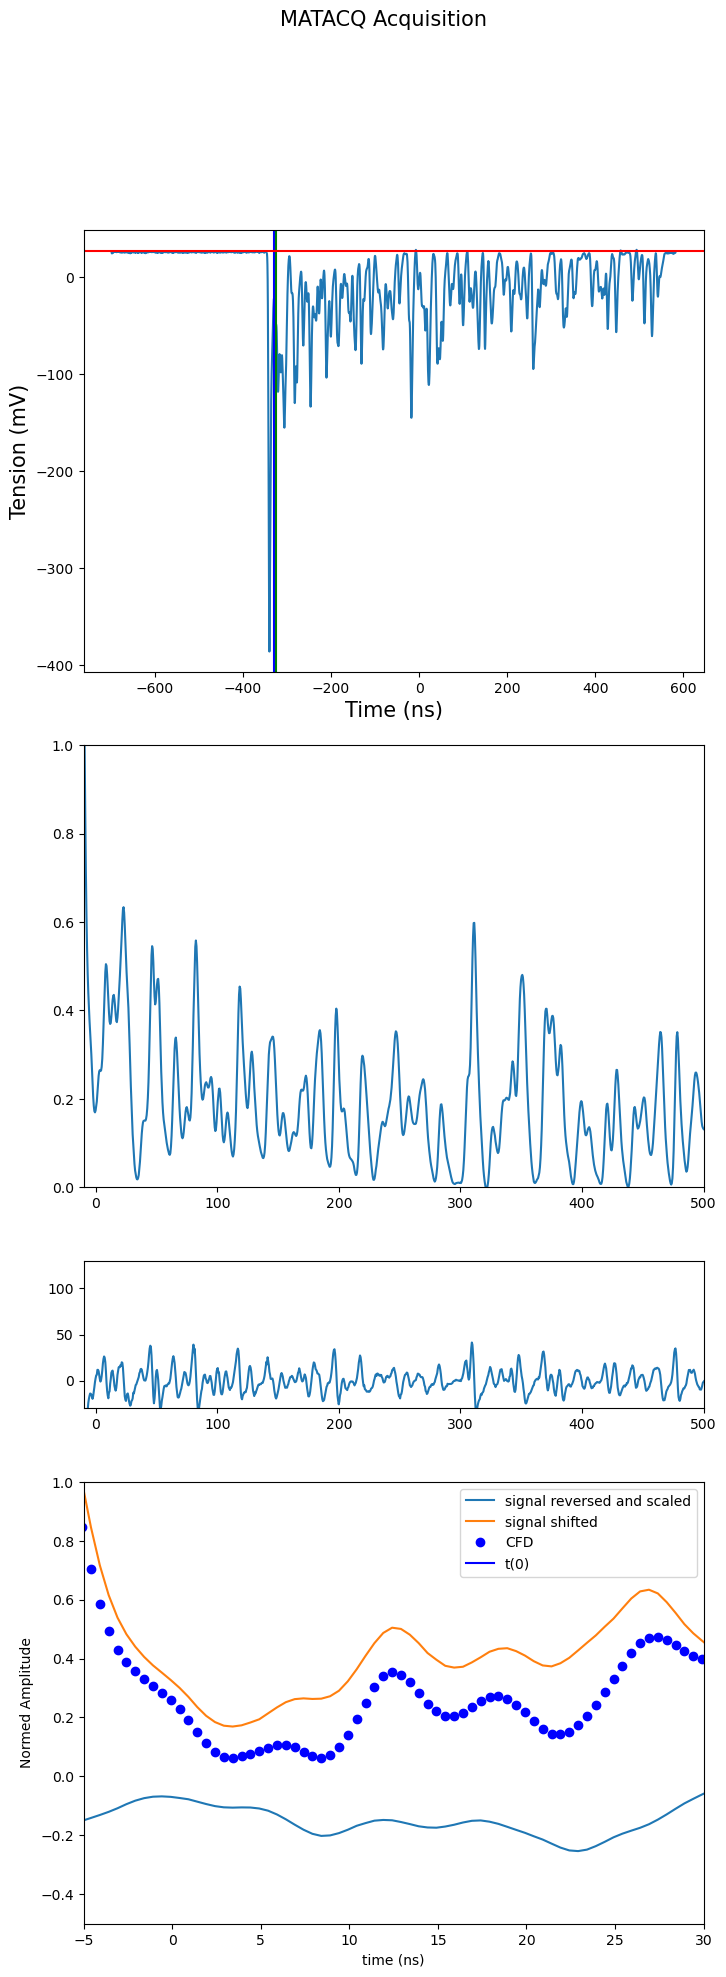

In [17]:


def plot_debug(n_plot):
    
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(4,1, gridspec_kw={'height_ratios': [3, 3, 1, 3]}, figsize = (8,22))
    fig.suptitle(
       "MATACQ Acquisition",
       fontsize=15,
    )
    
    df0 = df_temp.iloc[2560*n_plot:2560*(n_plot+1)]
    3
    ax1.plot(df0["t3"],df0["A3"],label='IN0')
    
    ax1.axvline(x = t_start3[n_plot], color = 'b', label = 't_start')
    ax1.axvline(x = t_max3[n_plot], color = 'g', label = 't_max')
    ax1.axhline(y = offset_A3[n_plot], color = 'r', label = 'offset')
    
    ax1.set_xlabel("Time (ns)", fontsize=15)
    ax1.set_ylabel("Tension (mV)", fontsize=15)
    
    ax2.plot(df0["t3"] - t_start3[n_plot] ,-(df0["A3"]-offset_A3[n_plot])/A_A3[n_plot],label='IN0')
    ax2.set_xlim(-10, 500)
    ax2.set_ylim(0, 1)
    # ax1.set_ylim(0, 25)
    
    # ax1.set_ylim(0, 25)
    
    ax3.plot(df0["t3"] - t_start3[n_plot] ,-df0["d3"],label='IN0')
    ax3.set_xlim(-10, 500)
    ax3.set_ylim(-30, 130)
    
    A3_norm = -(df0["A3"]-offset_A3[n_plot])/A_A3[n_plot]
    
    A3_norm_shifted = A3_norm.shift(periods=dl*2)
    
    A3_retourne_att = -A3_norm*0.4
    
    A3_sum = A3_norm_shifted + A3_retourne_att
    
    ax4.plot(df0["t3"] - t_start3[n_plot] , A3_retourne_att,label='signal reversed and scaled')
    ax4.plot(df0["t3"] - t_start3[n_plot] , A3_norm_shifted, label='signal shifted')
    ax4.plot(df0["t3"] - t_start3[n_plot]  , A3_sum,"bo", label='CFD')
    
#     print(df0,df0.index[np.where(np.diff(np.sign(np.array(A3_sum))))])
    
    
    zeros_crossing = df0.iloc[np.where(np.diff(np.sign(np.array(A3_sum))))]
    
    CFD_A3_time = zeros_crossing[zeros_crossing['t3']>t_start3[n_plot]]['t3'].iloc[0]
    
    ax4.axvline(x = CFD_A3_time - t_start3[n_plot], color = 'b', label = 't(0)')
    
    ax4.set_xlim(-5, 30)
    ax4.set_ylim(-0.5, 1)    
    ax4.legend(fontsize=10)
    

    ax4.set_xlabel("time (ns)")
    ax4.set_ylabel("Normed Amplitude")






#
def plot_debug_m(n_plot):


    df0 = df_temp.iloc[2560*n_plot:2560*(n_plot+1)]
    plt.plot(df0["t3"] - t_start3[n_plot] ,-(df0["A3"]-offset_A3[n_plot])/A_A3[n_plot],label= f'{n_plot}')
    plt.xlim(-20,20)
    
    plt.ylim(0, 1)
    
    # ax1.set_ylim(0, 25)
    
    plt.legend(fontsize=10)
    
import random

# plot_debug_m(n_plot)    
# for k in range(5):
#     i=random.randint(0, N)
#     plot_debug_m(i)
#     print(i, Ishort[i]/Itot[i])


dl = 4
n_plot = 8
plot_debug(n_plot)

In [18]:
max(A)

952.5594

## Delay distribution

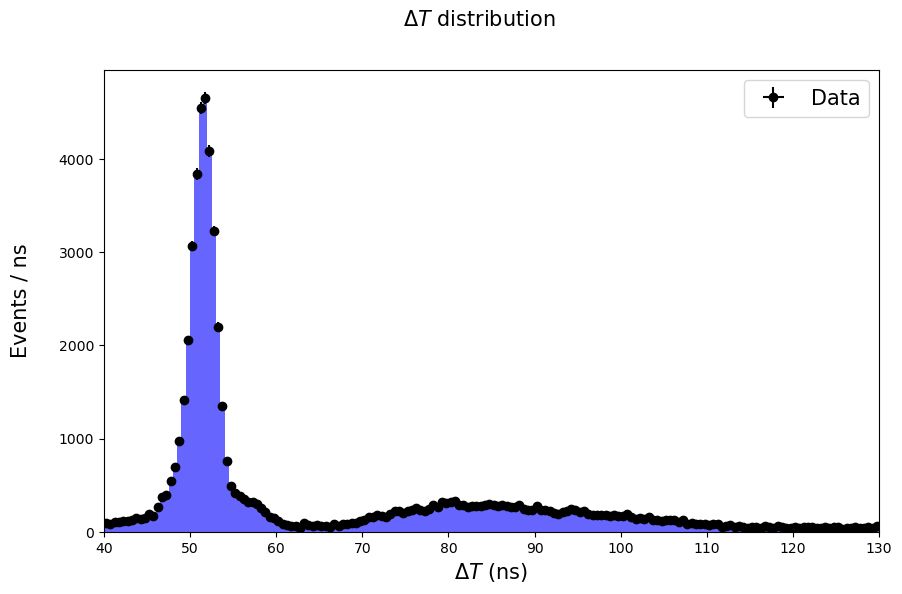

In [19]:
fig, ax1 = plt.subplots(figsize=(10,6))

diff = np.array(delay)

# # Plot the histogram.

tmin, tmax = 40,130
nbins = int((tmax-tmin)/0.5)


data_hist = np.histogram(diff, bins=nbins, range=(tmin, tmax))

ax1.hist(diff, range=[tmin,tmax], bins=nbins, alpha=0.6, color='b')

hist, bins = data_hist  # hist=frequency ; bins=Mass values
width = bins[1] - bins[0]

center = (bins[:-1] + bins[1:]) / 2

xerrs = [width * 0.5 for i in range(0, nbins)]
yerrs = np.sqrt(hist)


# Measured data
ax1.errorbar(
   center,
   hist,
   xerr=xerrs,
   yerr=yerrs,
   linestyle="None",
   color="black",
   marker="o",
   label="Data"
)

  
# # Plot the PDF.


fig.suptitle(
   "$\Delta T$ distribution",
   fontsize=15,
)
ax1.set_xlabel("$\Delta T$ (ns)", fontsize=15)
ax1.set_ylabel("Events / ns\n", fontsize=15)
# ax1.set_ylim(0, 25)
ax1.set_xlim(tmin, tmax)
ax1.legend(fontsize=15)





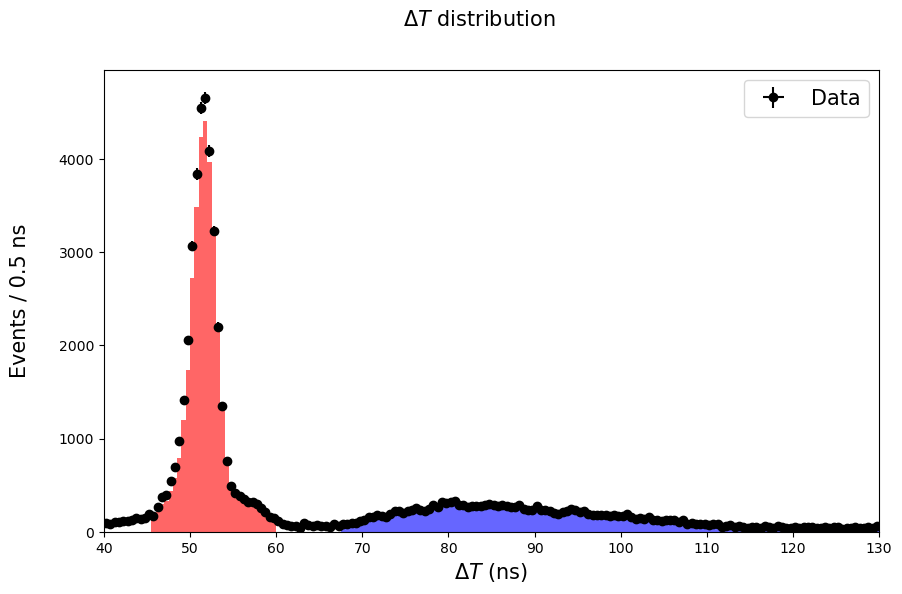

In [20]:
fig, ax1 = plt.subplots(figsize=(10,6))

diff = np.array(delay)

# # Plot the histogram.

tmin, tmax = 40,130
nbins = int((tmax-tmin)/0.5)


data_hist = np.histogram(diff, bins=nbins, range=(tmin, tmax))

hist, bins = data_hist
width = bins[1] - bins[0]
center = (bins[:-1] + bins[1:]) / 2
xerrs = [width * 0.5 for i in range(0, nbins)]
yerrs = np.sqrt(hist)

ax1.hist(delay_gammas, range=[tmin,tmax], bins=nbins, alpha=0.6, color='r')

ax1.hist(delay_neutrons, range=[tmin,tmax], bins=nbins, alpha=0.6, color='b')


# Measured data
ax1.errorbar(
   center,
   hist,
   xerr=xerrs,
   yerr=yerrs,
   linestyle="None",
   color="black",
   marker="o",
   label="Data"
)

  
# # Plot the PDF.


fig.suptitle(
   "$\Delta T$ distribution",
   fontsize=15,
)
ax1.set_xlabel("$\Delta T$ (ns)", fontsize=15)
ax1.set_ylabel("Events / 0.5 ns\n", fontsize=15)
# ax1.set_ylim(0, 25)
ax1.set_xlim(tmin, tmax)
ax1.legend(fontsize=15)





## 2D plots

Text(0, 0.5, 'Tail integral/Total integral $Ne213$')

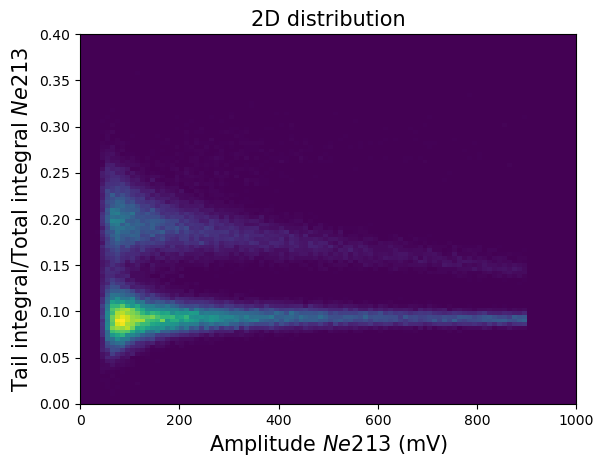

In [21]:
###################
#   2D PLOT 
###################

plt.title(
   "2D distribution",
   fontsize=15,
)

Amin = 0
Amax = 1000

A = np.array(A) 

diff

plt.hist2d(A[A<900], PSD[A<900], bins=100, range=[[Amin,Amax],[0,0.4]])
plt.xlabel("Amplitude $Ne213$ (mV)", fontsize=15)
plt.ylabel("Tail integral/Total integral $Ne213$", fontsize=15)


Text(0, 0.5, 'Tail integral/Total integral $Ne213$')

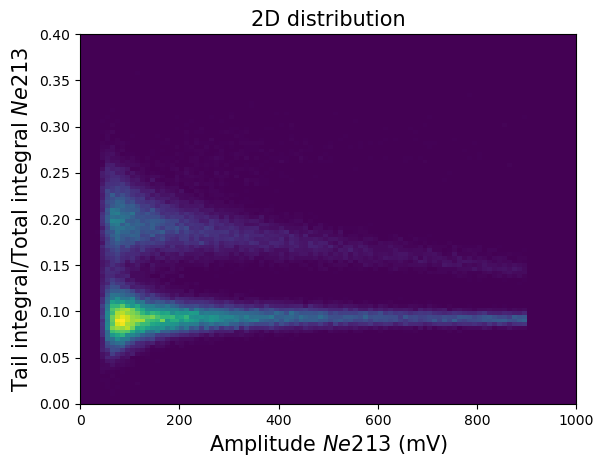

In [64]:
plt.title(
   "2D distribution",
   fontsize=15,
)


plt.hist2d(A_0, PSD_0, bins=100, range=[[Amin,Amax],[0,0.4]])
plt.xlabel("Amplitude $Ne213$ (mV)", fontsize=15)
plt.ylabel("Tail integral/Total integral $Ne213$", fontsize=15)

Text(0, 0.5, 'PSD $Ne213$')

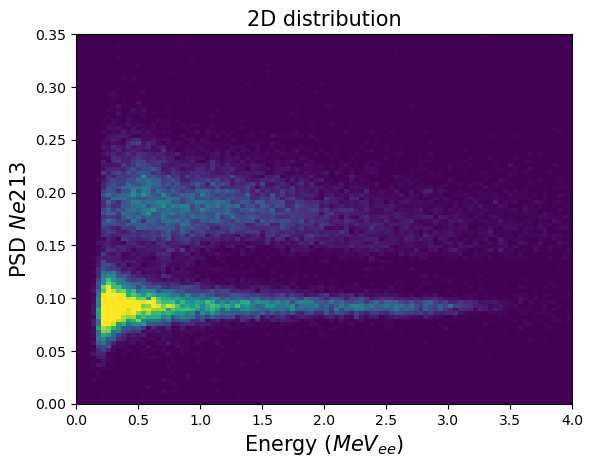

In [83]:
plt.title(
   "2D distribution",
   fontsize=15,
)




plt.hist2d(E_all_eq, PSD_all_eq, bins=100, range=[[0,4],[0,0.35]],vmax=70)
plt.xlabel("Energy ($MeV_{ee}$)", fontsize=15)
plt.ylabel("PSD $Ne213$", fontsize=15)

In [76]:
np.ones(5)+np.ones(5)

array([2., 2., 2., 2., 2.])

Text(700, 0.05, 'Gammas')

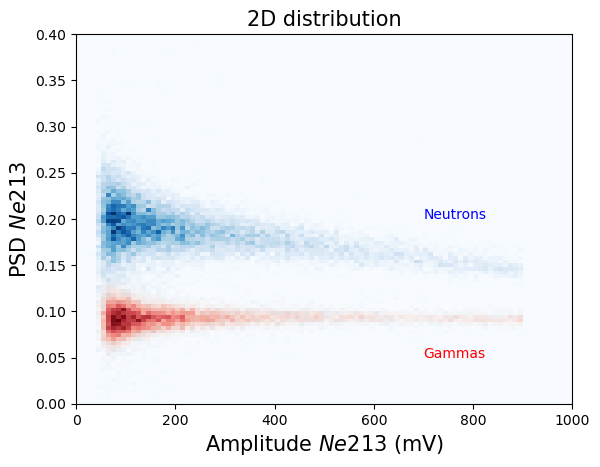

In [24]:
###################
#   2D PLOT 
###################

plt.title(
   "2D distribution",
   fontsize=15,
)
import matplotlib.pylab as pl
from matplotlib.colors import ListedColormap
Amin = 0 #mV
Amax = 1000 #mV


# modify existing Reds colormap with a linearly fading alpha
red = pl.cm.Reds  # original colormap
fading_red = red(np.arange(red.N)) # extract colors
fading_red[:, -1] = np.linspace(0, 1, red.N) # modify alpha
fading_red = ListedColormap(fading_red) # convert to colormap

plt.hist2d(A_neutrons, PSD_neutrons, bins=100, range=[[Amin,Amax],[0,0.4]], cmap="Blues",label="Neutrons")
plt.hist2d(A_gammas, PSD_gammas, bins=100, range=[[Amin,Amax],[0,0.4]], cmap=fading_red, label="$\gamma$")
plt.xlabel("Amplitude $Ne213$ (mV)", fontsize=15)
plt.ylabel("PSD $Ne213$", fontsize=15)



plt.text(700,0.2,"Neutrons",color='blue')
plt.text(700,0.05,"Gammas",color='red')


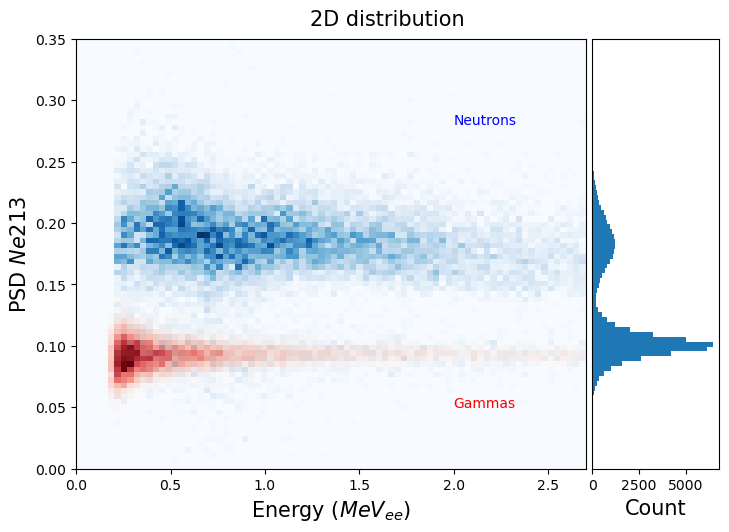

In [100]:
###################
#   2D PLOT 
###################


fig, (ax1, ax2) = plt.subplots(1,2, gridspec_kw={'width_ratios': [4, 1]},figsize=(7,5))

fig.suptitle(
   "2D distribution",
   fontsize=15,
)
import matplotlib.pylab as pl
from matplotlib.colors import ListedColormap

fig.tight_layout(pad=0.5)

# modify existing Reds colormap with a linearly fading alpha
red = pl.cm.Reds  # original colormap
fading_red = red(np.arange(red.N)) # extract colors
fading_red[:, -1] = np.linspace(0, 1, red.N) # modify alpha
fading_red = ListedColormap(fading_red) # convert to colormap

ax1.hist2d(E_neutrons, PSD_neutrons, bins=80, range=[[0,2.7],[0,0.35]], cmap="Blues",label="Neutrons")
ax1.hist2d(E_gammas, PSD_gammas, bins=80, range=[[0,2.7],[0,0.35]], cmap=fading_red, label="$\gamma$")
ax1.set_xlabel("Energy ($MeV_{ee}$)", fontsize=15)
ax1.set_ylabel("PSD $Ne213$", fontsize=15)

ax1.text(2,0.28,"Neutrons",color='blue')
ax1.text(2,0.05,"Gammas",color='red')

# ax1.axhline(y = 0.125, color = 'magenta')

# ax1.text(0.13,0.13,"PSD = 0.125",color='magenta')

_ = ax2.hist(PSD_all,range=[0,0.35],bins=80,orientation="horizontal")
ax2.set_xlabel("Count", fontsize=15)
ax2.get_yaxis().set_visible(False)
plt.subplots_adjust(wspace=0.02, hspace=0)
# ax2.axhline(y = 0.12, color = 'magenta')

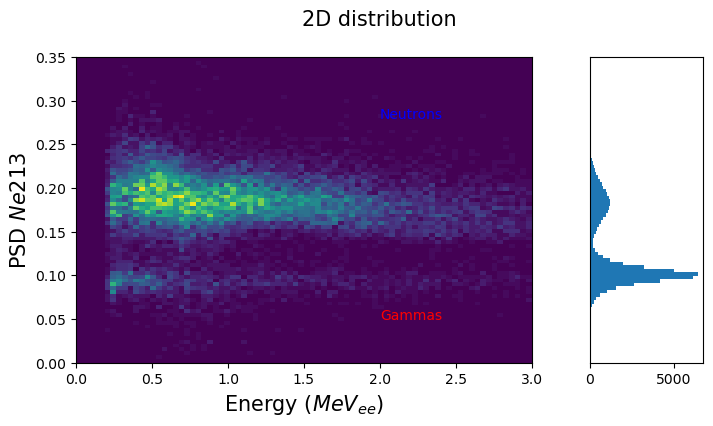

In [81]:
###################
#   2D PLOT 
###################


fig, (ax1, ax2) = plt.subplots(1,2, gridspec_kw={'width_ratios': [4, 1]},figsize=(7,4))

fig.suptitle(
   "2D distribution",
   fontsize=15,
)
import matplotlib.pylab as pl
from matplotlib.colors import ListedColormap

fig.tight_layout()

# modify existing Reds colormap with a linearly fading alpha
red = pl.cm.Reds  # original colormap
fading_red = red(np.arange(red.N)) # extract colors
fading_red[:, -1] = np.linspace(0, 1, red.N) # modify alpha
fading_red = ListedColormap(fading_red) # convert to colormap

ax1.hist2d(E_neutrons, PSD_neutrons, bins=80, range=[[0,3],[0,0.35]], label="Neutrons")
# ax1.hist2d(E_gammas, PSD_gammas, bins=80, range=[[0,3],[0,0.35]], label="$\gamma$")
ax1.set_xlabel("Energy ($MeV_{ee}$)", fontsize=15)
ax1.set_ylabel("PSD $Ne213$", fontsize=15)

ax1.text(2,0.28,"Neutrons",color='blue')
ax1.text(2,0.05,"Gammas",color='red')

# ax1.axhline(y = 0.125, color = 'magenta')

# ax1.text(0.13,0.13,"PSD = 0.125",color='magenta')

_ = ax2.hist(PSD_all,range=[0,0.35],bins=80,orientation="horizontal")
ax2.get_yaxis().set_visible(False)
# ax2.axhline(y = 0.12, color = 'magenta')

In [75]:
min(E_neutrons)

0.2145625264897717

(array([[0.000e+00, 4.000e+00, 5.000e+00, 9.000e+00, 3.000e+00, 4.000e+00,
         6.000e+00, 1.200e+01, 1.400e+01, 3.800e+01, 4.300e+01, 5.700e+01,
         1.180e+02, 2.120e+02, 3.480e+02, 4.470e+02, 3.850e+02, 1.980e+02,
         1.290e+02, 8.500e+01, 8.400e+01, 7.800e+01, 1.100e+02, 2.480e+02,
         4.560e+02, 5.920e+02, 9.300e+02, 1.112e+03, 1.409e+03, 1.567e+03,
         1.660e+03, 1.605e+03, 1.391e+03, 1.195e+03, 9.800e+02, 7.730e+02,
         5.540e+02, 4.330e+02, 3.110e+02, 2.230e+02, 1.710e+02, 1.130e+02,
         9.200e+01, 4.300e+01, 2.400e+01, 1.400e+01, 1.500e+01, 1.500e+01,
         6.000e+00, 3.000e+00],
        [0.000e+00, 5.000e+00, 6.000e+00, 1.000e+01, 5.000e+00, 1.100e+01,
         2.300e+01, 6.400e+01, 1.210e+02, 2.760e+02, 4.990e+02, 9.670e+02,
         1.898e+03, 3.641e+03, 6.808e+03, 8.901e+03, 6.508e+03, 3.501e+03,
         1.848e+03, 9.470e+02, 5.580e+02, 3.150e+02, 2.430e+02, 3.150e+02,
         5.060e+02, 6.190e+02, 9.490e+02, 1.139e+03, 1.437e+03, 1.59

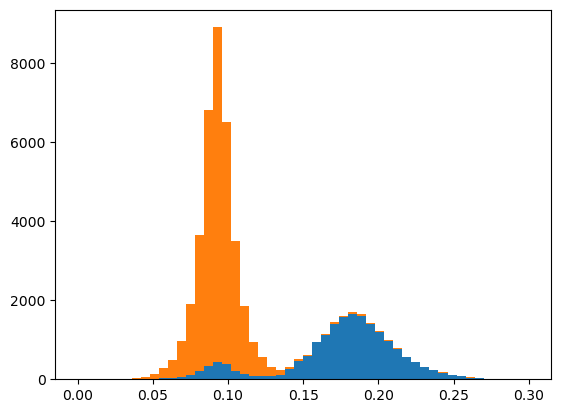

In [107]:
plt.hist([PSD_neutrons,PSD_gammas],range=[0,0.3],bins=50,stacked=True)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


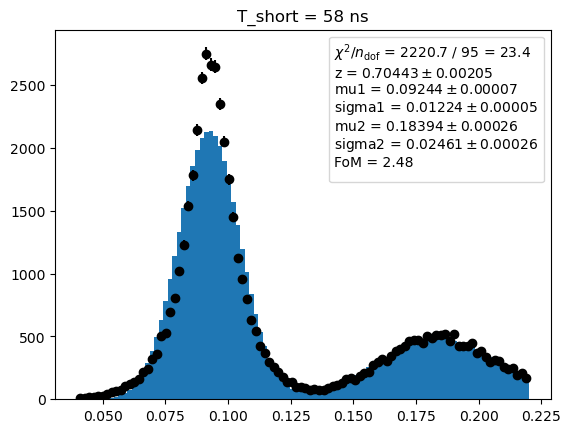

In [27]:
xr = (0.04, 0.22)
# plt.title(f"T_short = {T_short} ns")


nbins = 100

def cdf(xe, z, mu1, sigma1, mu2, sigma2):
    return (z * truncnorm.cdf(xe, *xr, mu1, sigma1) +
            (1-z) * truncnorm.cdf(xe, *xr, mu2, sigma2))

hist, bins = np.histogram(PSD_all,range=[xr[0],xr[1]],bins=100)

c = cost.BinnedNLL(hist, bins, cdf)


m = Minuit(c, z=0.6, mu1=0.08, mu2 =0.15, sigma1=0.005, sigma2=0.01)
m.limits["z"] = (0, 1)
m.limits["sigma1","sigma2"] = (0, 0.2)
m.limits["mu1","mu2"] = (0, 0.5)
m.migrad()
plt.figure()
plt.title(f"T_short = {T_short} ns")
m.visualize()
fit_info = [
f"$\\chi^2$/$n_\\mathrm{{dof}}$ = {m.fval:.1f} / {m.ndof:.0f} = {m.fmin.reduced_chi2:.1f}",
]
for p, v, e in zip(m.parameters, m.values, m.errors):
    fit_info.append(f"{p} = ${v:.5f} \\pm {e:.5f}$")


z,mu1,sigma1,mu2,sigma2 = m.values
FoM = abs(mu2-mu1)/(sigma1+sigma2)


fit_info.append(f"FoM = {FoM:.2f}")
plt.legend(title="\n".join(fit_info))

0.11836734693877551


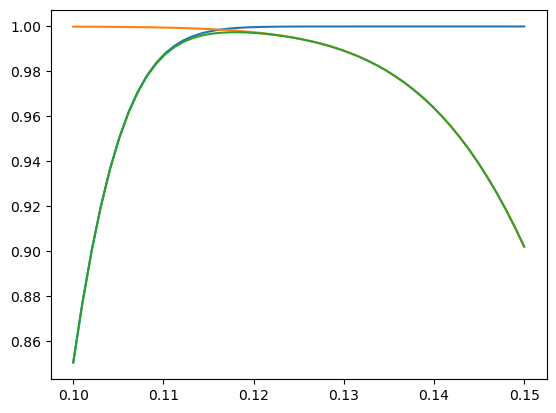

In [28]:
from scipy.stats import norm

R = 0.66992

x = np.linspace(0.1,0.15, 50 )

fom1 = (norm.cdf(x, loc=0.09132, scale=0.00835)*R)/(R*norm.cdf(x, loc=0.09132, scale=0.00835)+ R*norm.sf(x, loc=0.09132, scale=0.00835))
# plt.plot(x,fom1)   

fom2 = ((1-R)*norm.sf(x, loc=0.17576, scale=0.01991))/((1-R)*norm.sf(x, loc=0.17576, scale=0.01991) + (1-R)*norm.cdf(x, loc=0.17576, scale=0.01991 ))
                                                                                        
plt.plot(x, fom1)
plt.plot(x, fom2)

plt.plot(x, fom1*fom2)

print(x[np.argmax(fom1*fom2)])

0.1163265306122449

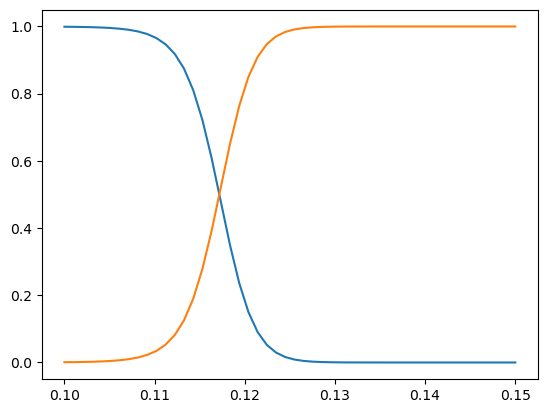

In [29]:

R = 0.66992
x = np.linspace(0.1,0.15, 50 )
p_gamma = norm.pdf(x, loc=0.09132, scale=0.00835)*R/(R*norm.pdf(x, loc=0.09132, scale=0.00835) + norm.pdf(x, loc=0.17576, scale=0.01991) )
plt.plot(x, p_gamma)

p_neutron = 1 - p_gamma
plt.plot(x, p_neutron)

x[np.argmin(p_gamma[p_gamma>0.5])]



In [30]:
 [f"100k_cf_80_{i}.ecor" for i in range(8)] 

['100k_cf_80_0.ecor',
 '100k_cf_80_1.ecor',
 '100k_cf_80_2.ecor',
 '100k_cf_80_3.ecor',
 '100k_cf_80_4.ecor',
 '100k_cf_80_5.ecor',
 '100k_cf_80_6.ecor',
 '100k_cf_80_7.ecor']

In [31]:
filenames = [f"100k_cf_80/100k_cf_80_{i}.ecor" for i in range(8)] 
filenames+=[f"100k_cf_30/100k_cf_30_{i}.ecor" for i in range(8)] 

(array([0.000e+00, 0.000e+00, 3.000e+00, 5.000e+00, 3.000e+00, 3.000e+00,
        7.000e+00, 3.000e+00, 2.000e+00, 7.000e+00, 1.300e+01, 1.400e+01,
        3.100e+01, 4.500e+01, 7.300e+01, 1.160e+02, 1.620e+02, 2.360e+02,
        3.580e+02, 5.240e+02, 7.250e+02, 1.134e+03, 1.638e+03, 2.424e+03,
        3.475e+03, 4.757e+03, 5.284e+03, 4.764e+03, 3.563e+03, 2.428e+03,
        1.680e+03, 1.125e+03, 7.750e+02, 5.330e+02, 4.070e+02, 2.800e+02,
        1.910e+02, 1.570e+02, 1.500e+02, 1.540e+02, 1.870e+02, 2.610e+02,
        3.270e+02, 3.410e+02, 4.510e+02, 5.570e+02, 5.950e+02, 7.150e+02,
        8.050e+02, 9.140e+02, 9.000e+02, 9.540e+02, 1.014e+03, 9.530e+02,
        9.360e+02, 8.040e+02, 8.250e+02, 7.240e+02, 6.020e+02, 5.690e+02,
        4.850e+02, 4.060e+02, 3.440e+02, 2.860e+02, 2.410e+02, 2.140e+02,
        1.560e+02, 1.450e+02, 1.060e+02, 1.000e+02, 8.800e+01, 6.300e+01,
        5.300e+01, 5.100e+01, 2.300e+01, 2.300e+01, 1.500e+01, 6.000e+00,
        1.000e+01, 1.100e+01, 1.200e+0

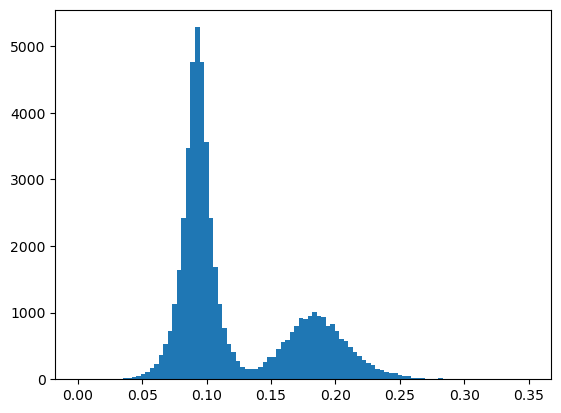

In [32]:
plt.hist(PSD_all,range=[0,0.35],bins=100)

(0.5, 1.0)

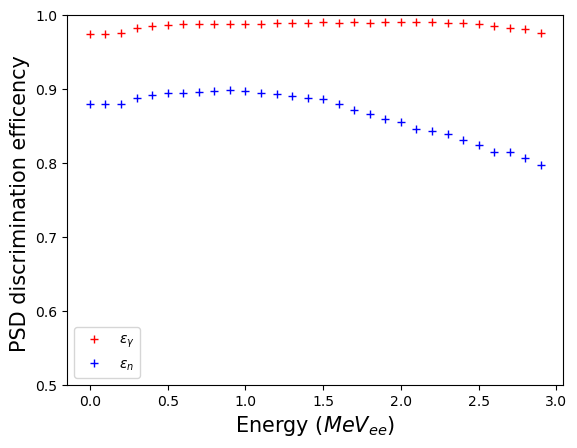

In [33]:
energies = np.linspace(0,2.9,30)

eff_gammas = []
eff_neutrons = []

for energy in energies :
    PSD_neutrons_temp = PSD_neutrons[E_neutrons>energy]
    PSD_gammas_temp = PSD_gammas[E_gammas>energy]
    eff_neutrons.append(len(PSD_neutrons_temp[PSD_neutrons_temp>0.125])/len(PSD_neutrons_temp))
    eff_gammas.append(len(PSD_gammas_temp[PSD_gammas_temp<0.125])/len(PSD_gammas_temp))
    
plt.plot(energies,eff_gammas,"r+",label="$\epsilon_\gamma $ ")
plt.plot(energies,eff_neutrons,"b+",label="$\epsilon_n $")
plt.legend()
plt.xlabel("Energy ($MeV_{ee}$)", fontsize=15)
plt.ylabel("PSD discrimination efficency ", fontsize=15)
plt.ylim([0.5,1])

In [34]:
# X = np.concatenate([PSD_all.T,E_all.T],axis=1)
len(PSD_all),len(E_all)



(53618, 53618)

In [35]:
psd_cuts = np.linspace(0.05,0.2,100)

efficencies = np.zeros((100,2))

for i,psd_cut in enumerate(psd_cuts) :
    efficencies[i,0] = len(PSD_neutrons_temp[PSD_neutrons_temp>psd_cut])/len(PSD_neutrons_temp)
    efficencies[i,1] = len(PSD_gammas_temp[PSD_gammas_temp<psd_cut])/len(PSD_gammas_temp)
    

0.10303030303030304

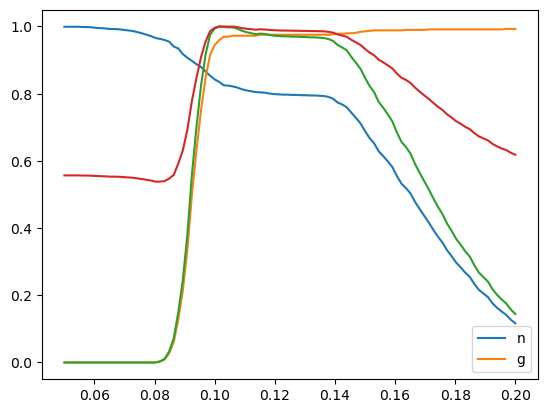

In [36]:
mult = efficencies[:,1]*efficencies[:,0]
add = efficencies[:,1]+efficencies[:,0]


plt.plot(psd_cuts, efficencies[:,0],label='n')
plt.plot(psd_cuts, efficencies[:,1],label='g')
plt.plot(psd_cuts, mult/max(mult))
plt.plot(psd_cuts, add/max(add))
plt.legend()
psd_cuts[np.argmax(add)]

(array([1.1800e+02, 2.7000e+01, 1.6000e+01, 1.3000e+01, 1.2000e+01,
        2.7000e+01, 2.0000e+01, 1.4000e+01, 1.1000e+01, 1.6000e+01,
        4.2000e+01, 3.7000e+01, 3.1000e+01, 4.3000e+01, 6.0000e+01,
        1.7200e+02, 1.0000e+02, 1.1700e+02, 1.3800e+02, 1.8300e+02,
        4.1600e+02, 2.6700e+02, 2.9100e+02, 3.2600e+02, 4.1000e+02,
        1.0300e+03, 7.5600e+02, 8.3300e+02, 9.7800e+02, 1.2820e+03,
        3.3560e+03, 2.6970e+03, 3.4710e+03, 4.5770e+03, 5.4240e+03,
        1.0898e+04, 6.0610e+03, 7.0210e+03, 7.6530e+03, 8.8660e+03,
        1.7261e+04, 5.7930e+03, 2.1490e+03, 5.1700e+02, 9.8000e+01,
        3.4000e+01, 4.0000e+00, 6.0000e+00, 3.0000e+00, 3.0000e+00]),
 array([20. , 20.6, 21.2, 21.8, 22.4, 23. , 23.6, 24.2, 24.8, 25.4, 26. ,
        26.6, 27.2, 27.8, 28.4, 29. , 29.6, 30.2, 30.8, 31.4, 32. , 32.6,
        33.2, 33.8, 34.4, 35. , 35.6, 36.2, 36.8, 37.4, 38. , 38.6, 39.2,
        39.8, 40.4, 41. , 41.6, 42.2, 42.8, 43.4, 44. , 44.6, 45.2, 45.8,
        46.4, 47. , 47

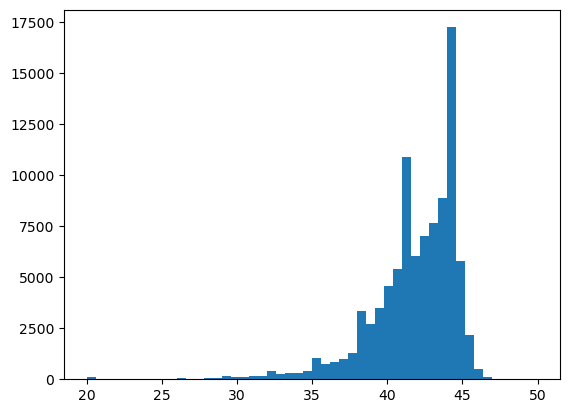

In [37]:
plt.hist(np.array(t_CFD_A4)-np.array(t_start),bins=50,range=[20,50])

Text(0, 0.5, 'PSD $Ne213$')

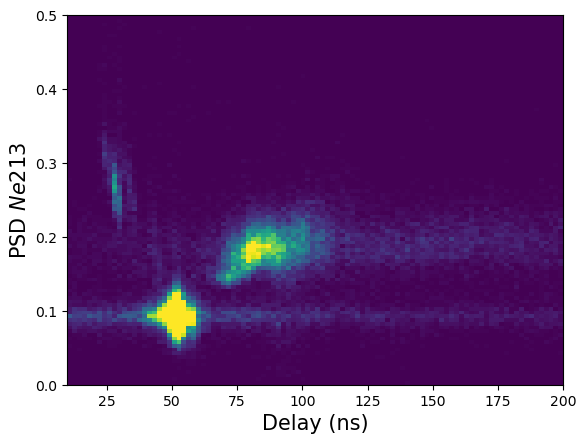

In [38]:
delta = np.array(t_CFD_A4)-np.array(t_start)

len(delta[delta<50])

plt.hist2d(delay_arr, PSD, bins=100, range=[[10,200],[0,0.5]],vmax=100)
plt.xlabel("Delay (ns)", fontsize=15)
plt.ylabel("PSD $Ne213$", fontsize=15)

Text(0, 0.5, 'PSD $Ne213$')

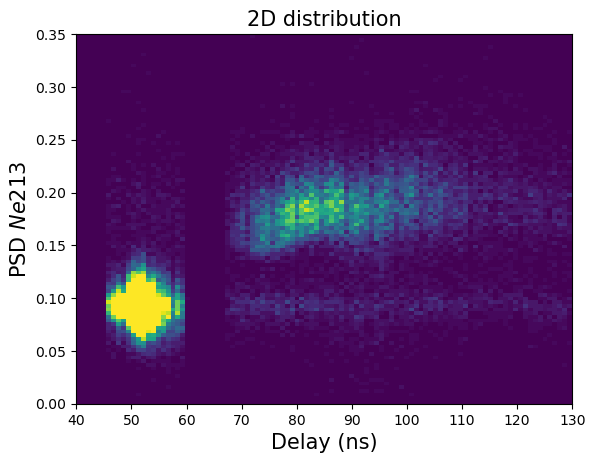

In [39]:
plt.title(
   "2D distribution",
   fontsize=15,
)


z, x, y, _ = plt.hist2d(delay_all[np.logical_not((PSD_all<0.00012)&(delay_all>60005))], PSD_all[np.logical_not((PSD_all<0.000012)&(delay_all>60005))], bins=100, range=[[40,130],[0,0.35]],vmax=50)
plt.xlabel("Delay (ns)", fontsize=15)
plt.ylabel("PSD $Ne213$", fontsize=15)

In [40]:
np.max(z)

1398.0

In [41]:
def fmt(x):
    if x<30 :
        return f"$2\sigma$"
    else :
        return f"$1\sigma$"

def fmt1(x):
    if x<7 :
        return f"$2\sigma$"
    else :
        return f"$1\sigma$"

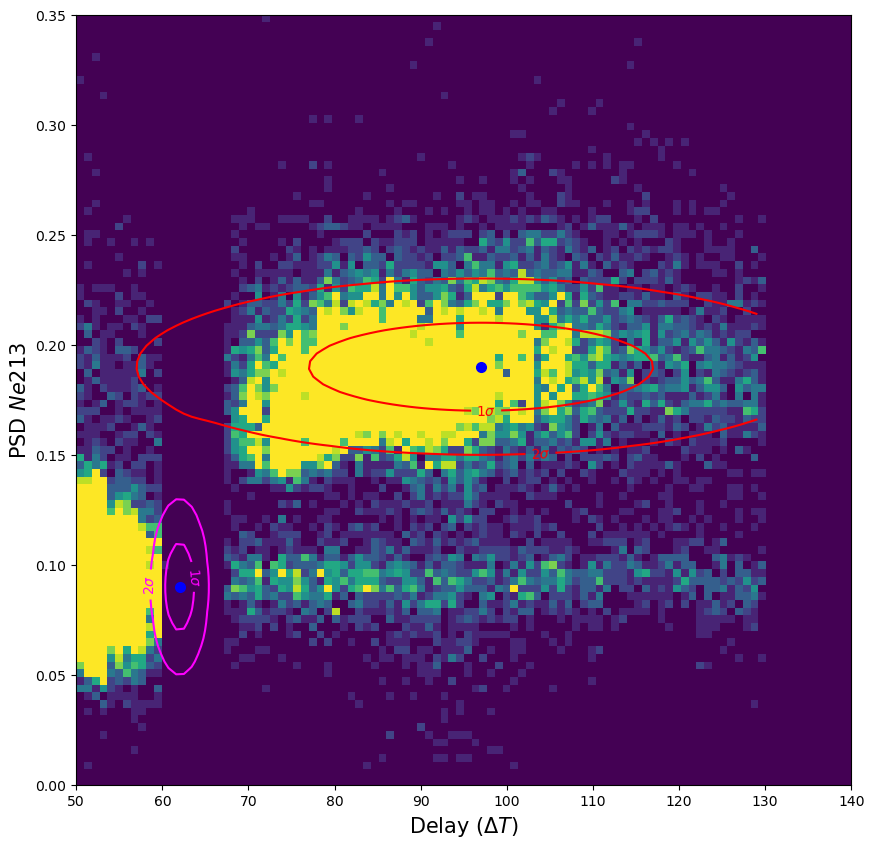

In [42]:
from scipy import optimize as opt

def twoD_Gaussian(amp0, x0, y0, amp1=10, x1=90, y1=0.18, sigma_x0=5, sigma_y0=0.02, sigma_x1=20, sigma_y1=0.02):

    x0 = float(x0)
    y0 = float(y0)
    x1 = float(x1)
    y1 = float(y1)
    
    return lambda x, y:  (amp0*np.exp(-(((x0-x)/sigma_x0)**2+((y0-y)/sigma_y0)**2)/2))+(
                             amp1*np.exp(-(((x1-x)/sigma_x1)**2+((y1-y)/sigma_y1)**2)/2))

def twoD_GaussianCF(xy, amp0, x0, y0, amp1=10, x1=90, y1=0.18, sigma_x0=5, sigma_y0=0.02 , sigma_x1=20, sigma_y1=0.02):

    x0 = float(x0)
    y0 = float(y0)
    x1 = float(x1)
    y1 = float(y1)
    
    
    

    g = (amp0*np.exp(-(((x0-xy[0])/sigma_x0)**2+((y0-xy[1])/sigma_y0)**2)/2))+(
        amp1*np.exp(-(((x1-xy[0])/sigma_x1)**2+((y1-xy[1])/sigma_y1)**2)/2))

    return g.ravel()


p = z


X, Y = np.meshgrid(x[0:100], y[0:100] )
xy = (X,Y)

N_points = 2
display_width = 80

Amp = (213,12)
px = (62, 97)
py = (0.09, 0.19)
sigma_x = (1.67, 20)
sigma_y = (0.02, 0.02)


initial_guess_sum = (Amp[0], px[0], py[0], Amp[1], px[1], py[1],sigma_x[0], sigma_y[0],sigma_x[1], sigma_y[1])

# popt, pcov = opt.curve_fit(twoD_GaussianCF, xy, np.ravel(p), p0=initial_guess_sum)

popt = initial_guess_sum

data_fitted= twoD_Gaussian(*popt)(X,Y)

peaks = [(popt[1],popt[2]), (popt[4],popt[5])]

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
ax.hist2d(delay_all[np.logical_not((PSD_all<0.0)&(delay_all>750))], PSD_all[np.logical_not((PSD_all<0.00012)&(delay_all>7500))], bins=100, range=[[50,140],[0,0.35]],vmax=10)

import copy
data_fitted1 = copy.copy(data_fitted)

sigmas0 = [popt[0]*norm.pdf(i)*np.sqrt(2*np.pi) for i in range(2,0,-1)]
# data_fitted[data_fitted<sigmas0[0]*0.5]=0
CS = ax.contour(X,Y,data_fitted,sigmas0 , colors='magenta')
ax.clabel(CS, fmt=fmt, fontsize=10)



data_fitted1[(X<67.5)&(Y<0.155)]=0
sigmas1 = [popt[3]*norm.pdf(i)*np.sqrt(2*np.pi) for i in range(2,0,-1)]
CS1 = ax.contour(X,Y,data_fitted1,sigmas1, colors='r')
ax.clabel(CS1, fmt=fmt1, fontsize=10)
ax.set_xlabel("Delay ($\Delta T$)", fontsize=15)
ax.set_ylabel("PSD $Ne213$", fontsize=15)

# ax.set_xlim(np.int(RC[0])-135, np.int(RC[0])+135)
# ax.set_ylim(np.int(RC[1])+135, np.int(RC[1])-135)

for k in range(0,N_points):
    plt.plot(peaks[k][0],peaks[k][1],'bo',markersize=7)
plt.show()

In [43]:
popt
sigmas0

# plt.imshow(data_fitted)

[28.826415329398507, 129.1910305187909]

In [44]:
twoD_GaussianCF(xy,*initial_guess_sum).shape

(10000,)

In [45]:
data_fitted[data_fitted<10].shape

data_fitted[data_fitted>10]=0

In [46]:
[popt[3]*norm.pdf(i)*np.sqrt(2*np.pi) for i in range(3,0,-1)]

[0.1333079584589077, 1.6240233988393524, 7.278367916551601]

In [47]:
X.shape

(100, 100)

In [48]:
from sklearn.mixture import GaussianMixture as GMM

X = np.array([delay_all, PSD_all]).T

# gmm = GMM(n_components=2).fit(X)
# labels = gmm.predict(X)



from matplotlib.patches import Ellipse

def draw_ellipse(position, covariance, ax=None, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    ax = ax or plt.gca()
    
    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
    
    # Draw the Ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height,
                             angle, ec='red', lw=1.5, fill=False, **kwargs))
        
def plot_gmm(gmm, X, label=True, ax=None):
    ax = ax or plt.gca()
    labels = gmm.fit(X).predict(X)
    if label:
#         ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)
        ax.hist2d(delay_arr, PSD, bins=100, range=[[30,140],[0,0.35]],vmax=50)
        ax.set_xlabel("Delay (ns)", fontsize=15)
        ax.set_ylabel("PSD $Ne213$", fontsize=15)
        
    else:
        ax.scatter(X[:, 0], X[:, 1], s=40, zorder=2)
#     ax.axis('equal')
    
    w_factor = 0.5 / gmm.weights_.max()
    for i, (pos, covar, w) in enumerate(zip(gmm.means_, gmm.covariances_, gmm.weights_)):
        if i == np.argmax(np.linalg.det(gmm.covariances_)):
            continue
        draw_ellipse(pos, covar, alpha=0.8)

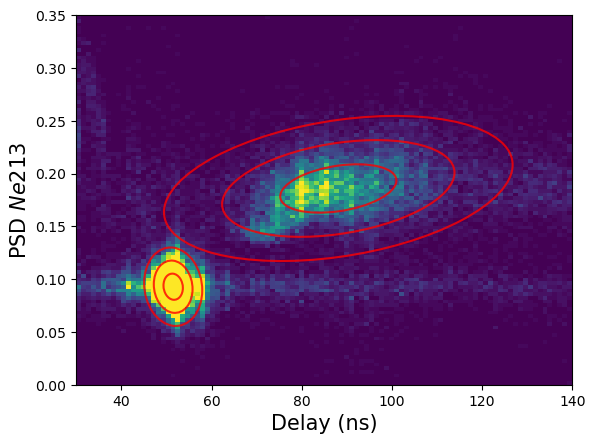

In [49]:
gmm = GMM(n_components=3)#, weights_init=[0.6,0.1,0.3])
plot_gmm(gmm, X)


In [50]:
gmm.weights_

array([0.64222738, 0.26606426, 0.09170835])

In [51]:
gmm.means_

array([[51.48976014,  0.09280576],
       [88.1110537 ,  0.18584502],
       [92.75848161,  0.14352254]])

In [52]:
gmm.covariances_

array([[[ 4.61441431e+00, -2.39763686e-03],
        [-2.39763686e-03,  1.53383309e-04]],

       [[ 1.66041110e+02,  9.61900933e-02],
        [ 9.61900933e-02,  5.24553809e-04]],

       [[ 4.20854899e+02,  8.51022297e-02],
        [ 8.51022297e-02,  9.13108680e-03]]])

Text(0, 0.5, 'PSD $Ne213$')

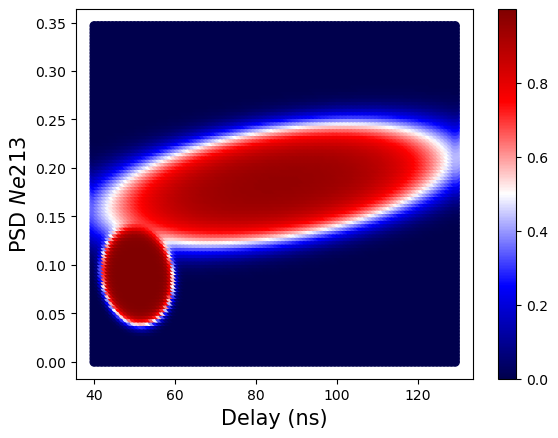

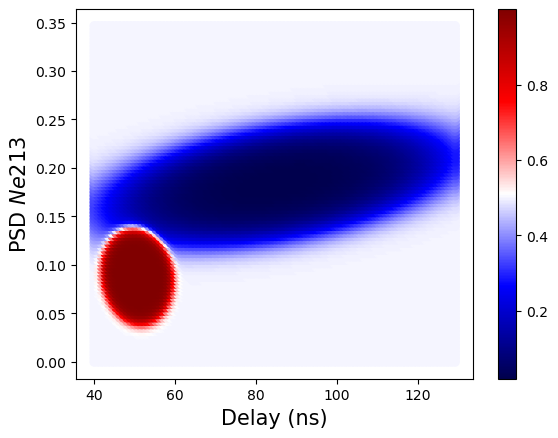

In [112]:
Xmesh, Ymesh = np.meshgrid(x[0:100], y[0:100] )

probs = gmm.predict_proba(np.array([Xmesh.ravel(),Ymesh.ravel()]).T)


plt.scatter(Xmesh, Ymesh,c=1-probs[:,np.argmax(np.linalg.det(gmm.covariances_))],cmap='seismic')
plt.colorbar()
plt.xlabel("Delay (ns)", fontsize=15)
plt.ylabel("PSD $Ne213$", fontsize=15)
plt.figure()
plt.scatter(Xmesh, Ymesh,c=0.5*probs[:,np.argmax(np.linalg.det(gmm.covariances_))]+probs[:,np.argmin(np.linalg.det(gmm.covariances_))],cmap='seismic')
plt.colorbar()
plt.xlabel("Delay (ns)", fontsize=15)
plt.ylabel("PSD $Ne213$", fontsize=15)

# plt.plot(delay_measured,PSD_measured,"+",c="chartreuse",ms=10,markeredgewidth=2)


In [54]:
delay_measured = 70
PSD_measured = 0.18
color=["chartreuse", "cyan","yellow","fuchsia"]



proba = gmm.predict_proba([[delay_measured,PSD_measured]])
liste = [0,1,2]
liste.remove(np.argmax(np.linalg.det(gmm.covariances_)))
liste.remove(np.argmin(np.linalg.det(gmm.covariances_)))

print(f"The event with a delay of {delay_measured}ns and a PSD of {PSD_measured} is likely to be :\n",f"Gamma : {proba[0,np.argmin(np.linalg.det(gmm.covariances_))]*100:.1f}%\n",f"Neutron : {proba[0,liste[0]]*100:.1f}%\n",f"Background : {proba[0,np.argmax(np.linalg.det(gmm.covariances_))]*100:.1f}% \n")




The event with a delay of 70ns and a PSD of 0.18 is likely to be :
 Gamma : 0.0%
 Neutron : 93.8%
 Background : 6.2% 



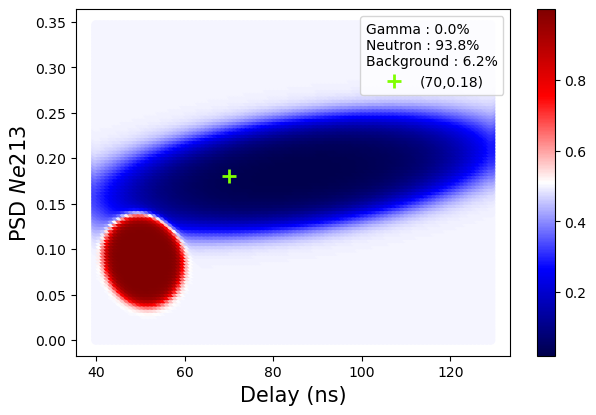

In [114]:
delay_measured = 70
PSD_measured = 0.18

plt.figure(figsize=(7,4.5))
plt.scatter(Xmesh, Ymesh,c=0.5*probs[:,np.argmax(np.linalg.det(gmm.covariances_))]+probs[:,np.argmin(np.linalg.det(gmm.covariances_))],cmap='seismic')
plt.colorbar()
plt.xlabel("Delay (ns)", fontsize=15)
plt.ylabel("PSD $Ne213$", fontsize=15)
plt.plot(delay_measured,PSD_measured,"+",c="chartreuse",ms=10,markeredgewidth=2,label=f"({delay_measured},{PSD_measured})")
plt.legend(title = f"Gamma : {proba[0,np.argmin(np.linalg.det(gmm.covariances_))]*100:.1f}%\n"+
          f"Neutron : {proba[0,liste[0]]*100:.1f}%\n"+
          f"Background : {proba[0,np.argmax(np.linalg.det(gmm.covariances_))]*100:.1f}%")



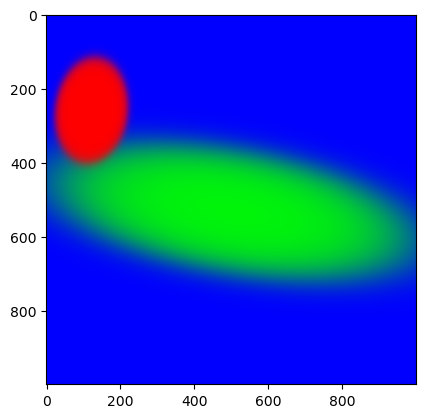

In [56]:
Xmesh1k, Ymesh1k = np.meshgrid(np.linspace(min(x),max(x),1000), np.linspace(min(y),max(y),1000) )

probs1k = gmm.predict_proba(np.array([Xmesh1k.ravel(),Ymesh1k.ravel()]).T)

plt.imshow(probs1k.reshape((1000,1000,3)))

In [70]:
n_neutrons_tof_psd = len(np.where((delay_arr>minTneutron)&(delay_arr<maxTneutron)&(PSD>0.13)&(A_arr<900))[0])
n_neutrons_tof = len(np.where((delay_arr>minTneutron)&(delay_arr<maxTneutron)&(A_arr<900))[0])
n_neutrons_psd = len(np.where((PSD>0.13)&(A_arr<900))[0])


n_gammas_tof_psd = len(np.where((delay_arr>minTgamma)&(delay_arr<maxTgamma)&(PSD<0.13)&(A_arr<900))[0])
n_gammas_tof = len(np.where((delay_arr>minTgamma)&(delay_arr<maxTgamma)&(A_arr<900))[0])
n_gammas_psd = len(np.where((PSD<0.13)&(A_arr<900))[0])

In [74]:
print(f"Purity neutrons ToF :{n_neutrons_tof_psd/n_neutrons_tof}, PSD : {n_neutrons_tof_psd/n_neutrons_psd}")
print(f"Purity gammas ToF :{n_gammas_tof_psd/n_gammas_tof}, PSD : {n_gammas_tof_psd/n_gammas_psd}")


Purity neutrons ToF :0.876040703052729, PSD : 0.48967363202238645
Purity gammas ToF :0.980704293294742, PSD : 0.5678957573367511
